Import Statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import hamming_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import pandas as pd
import io

Load training and test data

In [2]:
# IF RUNNING ON LOCAL JUPYTER SERVER USE THIS
# Load train.csv, test.csv, and test_labels.csv
# NOTE: Change file paths if needed.
training_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')
test_labels_csv = pd.read_csv('test_labels.csv')

Reformat imported csv's into np arrays

In [3]:
from ast import Str
# Training data
X_train = np.asarray(training_csv[training_csv.columns[1]])
Y_train = np.asarray(training_csv[training_csv.columns[2:]])

# Raw testing data
X_test_temp = np.asarray(test_csv[test_csv.columns[1]])
Y_test_temp = np.asarray(test_labels_csv[test_labels_csv.columns[1:]])

# Reformat the arrays since Y_test has -1 entries for some reason.
X_test = np.empty((len(X_test_temp)), dtype=object)
Y_test = np.empty((len(Y_test_temp), len(Y_test_temp[0])), dtype=np.int8)
size = 0

for i in range(len(Y_test_temp)):
  if Y_test_temp[i][0] < 0:
    continue
  X_test[size] = X_test_temp[i]
  Y_test[size] = Y_test_temp[i]
  size = size + 1
X_test = X_test[:size]
Y_test = Y_test[:size]

Create the learner:

In [17]:
toxic_learner= Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2500)),
    ('clf', MultiOutputClassifier(SGDClassifier(loss='modified_huber',class_weight={0 : 2, 1 : 1}))), # You can adjust max_iter and other parameters
])
# Note: MLPClassifier does not work for this project. Training time is several hours long with just 10 hidden nodes.
# Likely due to huge quantity and dimensionality of data.

In [18]:
toxic_learner.fit(X_train, Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=2500)),
                ('clf',
                 MultiOutputClassifier(estimator=SGDClassifier(class_weight={0: 2,
                                                                             1: 1},
                                                               loss='modified_huber')))])

In [11]:
# Function for manual input and response.
types = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

def predict_toxic_type(comment: str) -> str:
  predictions = toxic_learner.predict([comment])[0]
  # print("These are the predictions: ", predictions)
  return_str = "Predicted Types: "
  num_predictions = 0
  for i in range(len(predictions)):
    if predictions[i] > 0:
      return_str = return_str + types[i] + ", "
      num_predictions = num_predictions + 1
  if num_predictions == 0:
    return_str = return_str + "None"
  return return_str

In [23]:
print(predict_toxic_type("hi hows it going"))
print(predict_toxic_type("bitch"))
print(predict_toxic_type("dude omg can you shut the fuck up"))
print(predict_toxic_type("go away"))
print(predict_toxic_type("im gonna go have sex with your mom and you cant stop me"))
print(predict_toxic_type("idiot"))
print(predict_toxic_type("dude why are you so bad"))
print(predict_toxic_type("fuck"))
print(predict_toxic_type("crap"))
print(predict_toxic_type("poop"))
print(predict_toxic_type("kill"))

Predicted Types: None
Predicted Types: toxic, obscene, insult, 
Predicted Types: toxic, obscene, insult, 
Predicted Types: None
Predicted Types: toxic, 
Predicted Types: toxic, insult, 
Predicted Types: None
Predicted Types: toxic, obscene, insult, 
Predicted Types: toxic, 
Predicted Types: None
Predicted Types: toxic, 


Similar results to LR as the None was always detected, but did differ in classifying certain options like obscene or insult. 

# Default Parameter Accuracy Testing

In [20]:
Y_hat_train = toxic_learner.predict(X_train)
Y_hat_test = toxic_learner.predict(X_test)

In [21]:
# Uses a hamming loss, meaning the percentage each pair of returned values is wrong.
# Lower is better.
# 0.03452 for MultinomialNB()
# 0.02502 for LogisticRegression() but seems to perform better with manual inputs than the MultinomialNB()
# 0.02589 for SGDClassifier(), same manual performance as LogisticRegression()
print("Training Loss: ", round(hamming_loss(Y_train, Y_hat_train),5))
print("Testing Loss: ", round(hamming_loss(Y_test, Y_hat_test),5))

print("\nAccuracy Per Label:")
for label in range(0,6):
  print("Label: " + types[label])
  print("Training Loss: ", round(hamming_loss(Y_train[:,label], Y_hat_train[:,label]),5))
  print("Testing Loss: ", round(hamming_loss(Y_test[:,label], Y_hat_test[:,label]),5))
  print("Confusion Matrix: \n", confusion_matrix(Y_test[:,label], Y_hat_test[:,label], normalize='all'))
  print()

Training Loss:  0.02047
Testing Loss:  0.02542

Accuracy Per Label:
Label: toxic
Training Loss:  0.04713
Testing Loss:  0.06051
Confusion Matrix: 
 [[0.88274094 0.02207009]
 [0.03843509 0.05675388]]

Label: severe_toxic
Training Loss:  0.00982
Testing Loss:  0.00569
Confusion Matrix: 
 [[9.94107349e-01 1.56303729e-04]
 [5.53315202e-03 2.03194848e-04]]

Label: obscene
Training Loss:  0.02326
Testing Loss:  0.03465
Confusion Matrix: 
 [[0.93443059 0.00787771]
 [0.02677483 0.03091688]]

Label: threat
Training Loss:  0.00271
Testing Loss:  0.00309
Confusion Matrix: 
 [[9.96576948e-01 1.25042984e-04]
 [2.96977086e-03 3.28237832e-04]]

Label: insult
Training Loss:  0.03163
Testing Loss:  0.03806
Confusion Matrix: 
 [[0.94201132 0.0044234 ]
 [0.03363656 0.01992873]]

Label: identity_hate
Training Loss:  0.00823
Testing Loss:  0.01053
Confusion Matrix: 
 [[9.88355372e-01 5.15802307e-04]
 [1.00190691e-02 1.10975648e-03]]



## Testing various max_features for TfidfVectorizer()

In [41]:
# Max features set to powers of 2.
max_features = []
for i in range(0, 11):
  max_features.append(2**i)
hammingError_train = []
hammingError_test = []

for i in max_features:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(max_features=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(SGDClassifier())), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

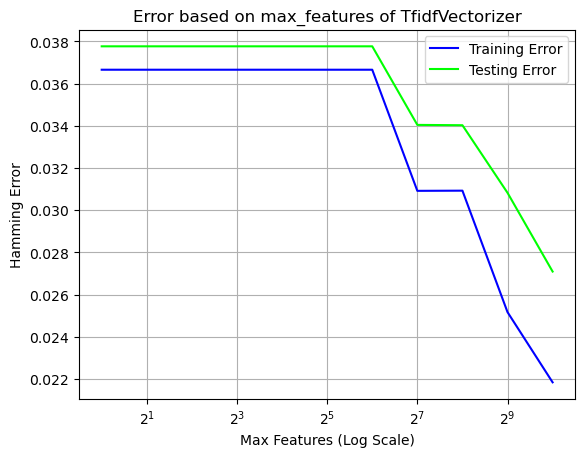

In [42]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.semilogx(max_features, hammingError_train, c="#0000FF", label="Training Error", base=2)
ax.semilogx(max_features, hammingError_test, c="#00FF00", label="Testing Error", base=2)
ax.set_title("Error based on max_features of TfidfVectorizer")
ax.set_xlabel("Max Features (Log Scale)")
ax.set_ylabel("Hamming Error")
ax.legend()
ax.grid()

It benefits from an increase in complexity. Very similar results as LR.

# Capitalization Accuracy Testing

In [43]:
#Use capitalization for generating features.
force_lowercase = [True, False]
hammingError_train = []
hammingError_test = []

for i in force_lowercase:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(lowercase=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(SGDClassifier())), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

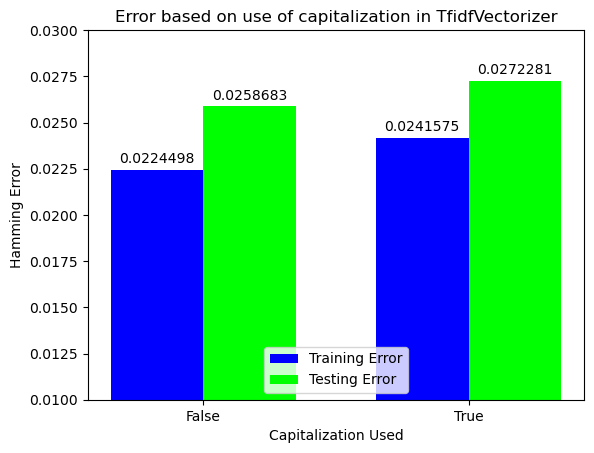

In [44]:
# Plot results
use_capitalization = ["False", "True"]
x = np.arange(len(use_capitalization))
fig, ax = plt.subplots(1,1)
training_rect = ax.bar(x, hammingError_train, color="#0000FF", label="Training Error", width = 0.35)
testing_rect = ax.bar(x + 0.35, hammingError_test, color="#00FF00", label="Testing Error", width = 0.35)
ax.bar_label(training_rect, padding=3)
ax.bar_label(testing_rect, padding=3)
ax.set_title("Error based on use of capitalization in TfidfVectorizer")
ax.set_xlabel("Capitalization Used")
ax.set_ylabel("Hamming Error")
ax.set_ylim(0.01,0.03)
ax.set_xticks(x + 0.175, use_capitalization)
ax.legend(loc='lower center')

Same results as LR, only different is that the error rates for training are higher than those of LR. 

# Removing accents accuracy.

In [46]:
# Strip accents for generating features.
strip_accents = [None, 'ascii', 'unicode']
hammingError_train = []
hammingError_test = []

for i in strip_accents:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(strip_accents=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(SGDClassifier())), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

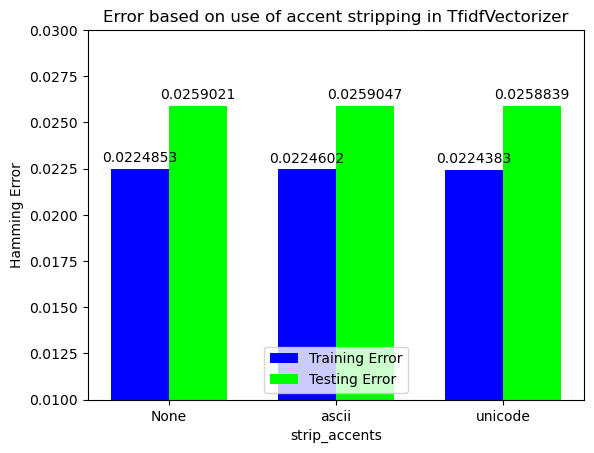

In [47]:
# Plot results
strip_accents_str = ['None','ascii', 'unicode']
x = np.arange(len(strip_accents_str))
fig, ax = plt.subplots(1,1)
training_rect = ax.bar(x, hammingError_train, color="#0000FF", label="Training Error", width = 0.35)
testing_rect = ax.bar(x + 0.35, hammingError_test, color="#00FF00", label="Testing Error", width = 0.35)
ax.bar_label(training_rect, padding=3)
ax.bar_label(testing_rect, padding=3)
ax.set_title("Error based on use of accent stripping in TfidfVectorizer")
ax.set_xlabel("strip_accents")
ax.set_ylabel("Hamming Error")
ax.set_ylim(0.01,0.03)
ax.set_xticks(x + 0.175, strip_accents_str)
ax.legend(loc='lower center')

Same results as LR, just has the higher training error.

# Max Document Frequency Accuracy

In [6]:
# Max_df set to powers of 0.7.
max_df = []
for i in range(0, 11):
  max_df.append(0.7**(i))
hammingError_train = []
hammingError_test = []

for i in max_df:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(max_df=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(SGDClassifier())), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

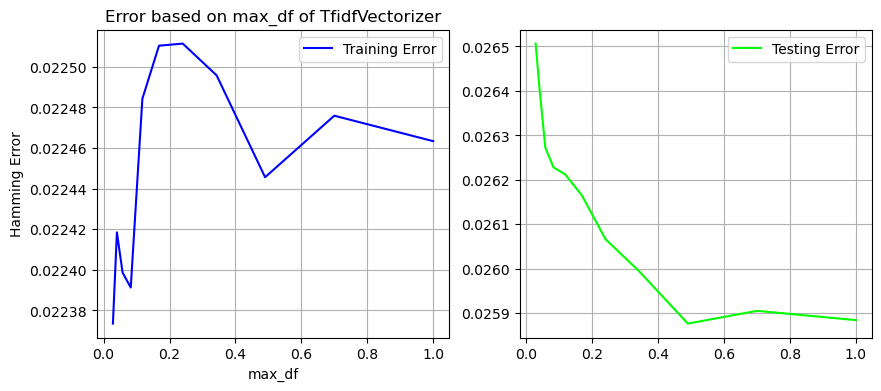

In [8]:
# Plot results
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(max_df, hammingError_train, c="#0000FF", label="Training Error")
ax[1].plot(max_df, hammingError_test, c="#00FF00", label="Testing Error")
ax[0].set_title("Error based on max_df of TfidfVectorizer")
ax[0].set_xlabel("max_df")
ax[0].set_ylabel("Hamming Error")
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

Very interesting results as the training error actually increaes as the max_df increases, but this trend does not exist with the testing error. Model looks like it is underfitting and could be an issue if a lot of the words in the dataset are very common so it would be decreases the dataset with the max_df increasing. Within both there is a dip between 0.4 and 0.6

# Min Document Frequency Accuracy

In [50]:
# min_df
min_df = np.arange(0.0,0.6,0.1)
hammingError_train = []
hammingError_test = []

for i in min_df:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(min_df=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(SGDClassifier())), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

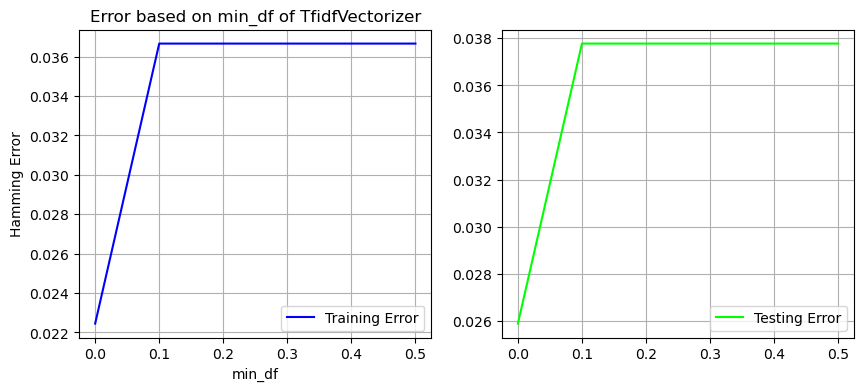

In [51]:
# Plot results
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(min_df, hammingError_train, c="#0000FF", label="Training Error")
ax[1].plot(min_df, hammingError_test, c="#00FF00", label="Testing Error")
ax[0].set_title("Error based on min_df of TfidfVectorizer")
ax[0].set_xlabel("min_df")
ax[0].set_ylabel("Hamming Error")
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

Basically identical to the results done by LR.

# Explore Different Loss Functions

In [53]:
# Use various solvers.
loss_functions = ['hinge', 'log_loss', 'modified_huber', 'perceptron']
hammingError_train = []
hammingError_test = []

for i in loss_functions:
  learner = Pipeline([
        ('tfidf', TfidfVectorizer()),  
        ('clf', MultiOutputClassifier(SGDClassifier(loss=i))), 
    ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

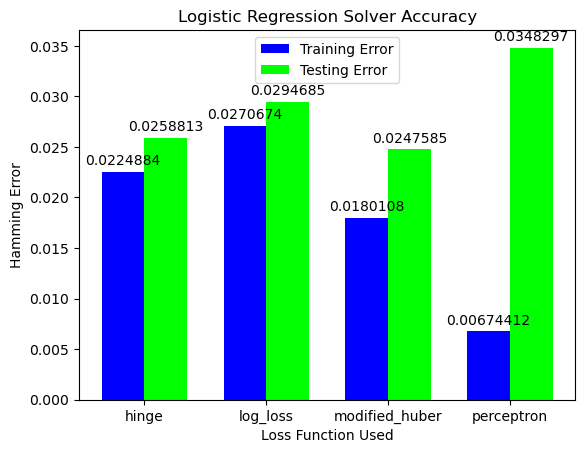

In [59]:
# Plot results
x = np.arange(len(loss_functions))
fig, ax = plt.subplots(1,1)
training_rect = ax.bar(x, hammingError_train, color="#0000FF", label="Training Error", width = 0.35)
testing_rect = ax.bar(x + 0.35, hammingError_test, color="#00FF00", label="Testing Error", width = 0.35)
ax.bar_label(training_rect, padding=3)
ax.bar_label(testing_rect, padding=3)
ax.set_title("Logistic Regression Solver Accuracy")
ax.set_xlabel("Loss Function Used")
ax.set_ylabel("Hamming Error")
ax.set_xticks(x + 0.175, loss_functions)
ax.legend(loc='upper center')

The different loss functions had big effects on the accuracy. Perceptron look like it actually ended up overfitting. Modified_huber looks like it had the best result.

# Class weights

In [9]:
# Use various solvers.
lr_class_weights = [None,'balanced', {0 : 1, 1 : 10}, {0 : 10, 1 : 1}]
hammingError_train = []
hammingError_test = []

for i in lr_class_weights:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer()),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(SGDClassifier(class_weight=i))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

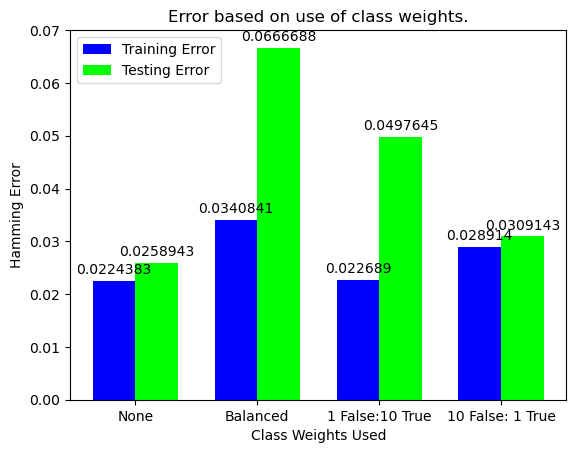

In [10]:
# Plot results
lr_class_weights_str = ['None','Balanced','1 False:10 True', '10 False: 1 True']
x = np.arange(len(lr_class_weights))
fig, ax = plt.subplots(1,1)
training_rect = ax.bar(x, hammingError_train, color="#0000FF", label="Training Error", width = 0.35)
testing_rect = ax.bar(x + 0.35, hammingError_test, color="#00FF00", label="Testing Error", width = 0.35)
ax.bar_label(training_rect, padding=3)
ax.bar_label(testing_rect, padding=3)
ax.set_title("Error based on use of class weights.")
ax.set_xlabel("Class Weights Used")
ax.set_ylabel("Hamming Error")
#ax.set_ylim(0.015,0.03)
ax.set_xticks(x + 0.175, lr_class_weights_str)
ax.legend(loc='upper left')

In [13]:
for label in range(0,6):
  print("Label: " + types[label])
  print("Training Loss: ", round(hamming_loss(Y_train[:,label], Y_hat_train[:,label]),5))
  print("Testing Loss: ", round(hamming_loss(Y_test[:,label], Y_hat_test[:,label]),5))
  print("Confusion Matrix: \n", confusion_matrix(Y_test[:,label], Y_hat_test[:,label], normalize='all'))
  print()

Label: toxic
Training Loss:  0.06821
Testing Loss:  0.07027
Confusion Matrix: 
 [[0.90148176 0.00332927]
 [0.06694489 0.02824408]]

Label: severe_toxic
Training Loss:  0.01
Testing Loss:  0.00574
Confusion Matrix: 
 [[0.99426365 0.        ]
 [0.00573635 0.        ]]

Label: obscene
Training Loss:  0.03455
Testing Loss:  0.04208
Confusion Matrix: 
 [[0.94016693 0.00214136]
 [0.0399356  0.0177561 ]]

Label: threat
Training Loss:  0.003
Testing Loss:  0.0033
Confusion Matrix: 
 [[0.99670199 0.        ]
 [0.00329801 0.        ]]

Label: insult
Training Loss:  0.04893
Testing Loss:  0.05297
Confusion Matrix: 
 [[9.46434712e-01 0.00000000e+00]
 [5.29713339e-02 5.93954172e-04]]

Label: identity_hate
Training Loss:  0.0088
Testing Loss:  0.01113
Confusion Matrix: 
 [[0.98887117 0.        ]
 [0.01112883 0.        ]]



In [7]:
# class_weights
class_weights = range(1,11)
hammingError_train = []
hammingError_test = []

for i in class_weights:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer()),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(SGDClassifier(loss='modified_huber',class_weight={0 : i, 1 : 1}))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

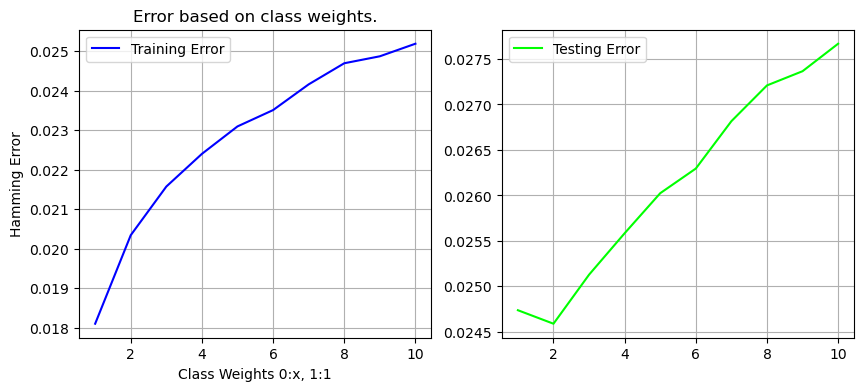

In [8]:
# Plot results
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(class_weights, hammingError_train, c="#0000FF", label="Training Error")
ax[1].plot(class_weights, hammingError_test, c="#00FF00", label="Testing Error")
ax[0].set_title("Error based on class weights.")
ax[0].set_xlabel("Class Weights 0:x, 1:1")
ax[0].set_ylabel("Hamming Error")
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

# max_iter accuracy 

In [16]:
# Max features set to powers of 2.
max_iter = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 7500, 10000]
hammingError_train = []
hammingError_test = []

for i in max_iter:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer()),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(SGDClassifier(max_iter=i))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\brian\miniconda3\envs\cs178\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\brian\AppData\Local\Temp\ipykernel_12840\1640371462.py", line 12, in <module>
    learner.fit(X_train, Y_train)
  File "c:\Users\brian\miniconda3\envs\cs178\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\brian\miniconda3\envs\cs178\Lib\site-packages\sklearn\pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\brian\miniconda3\envs\cs178\Lib\site-packages\sklearn\pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\brian\miniconda3\envs\cs178\Lib\site-p

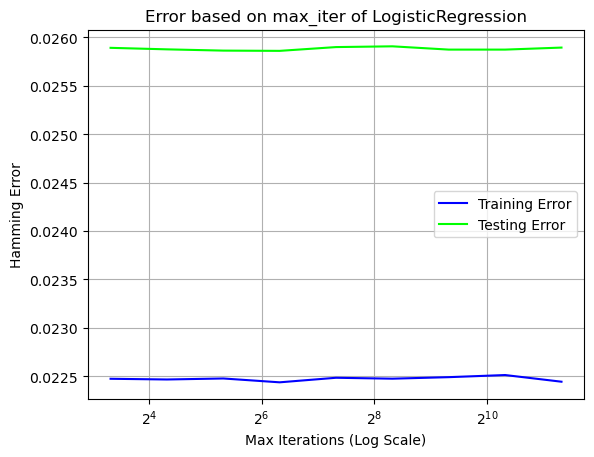

In [15]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.semilogx(max_iter, hammingError_train, c="#0000FF", label="Training Error", base=2)
ax.semilogx(max_iter, hammingError_test, c="#00FF00", label="Testing Error", base=2)
ax.set_title("Error based on max_iter of LogisticRegression")
ax.set_xlabel("Max Iterations (Log Scale)")
ax.set_ylabel("Hamming Error")
ax.legend()
ax.grid()